In [4]:
import torchvision
import torch.nn as nn
import torch
import torch.nn.functional as F
from torchvision import transforms, models, datasets
from torchsummary import summary
import numpy as np, pandas as pd, os, glob, cv2
from torch.utils.data import TensorDataset,DataLoader,Dataset
from copy import deepcopy
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import cluster
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [5]:
!git clone https://github.com/udacity/P1_Facial_Keypoints.git

Cloning into 'P1_Facial_Keypoints'...
remote: Enumerating objects: 5984, done.
remote: Total 5984 (delta 0), reused 0 (delta 0), pack-reused 5984
Receiving objects: 100% (5984/5984), 329.49 MiB | 14.14 MiB/s, done.
Resolving deltas: 100% (126/126), done.


In [6]:
!cd P1_Facial_Keypoints

In [7]:
root_dir = 'P1_Facial_Keypoints/data/training/'

In [8]:
all_img_paths = glob.glob(os.path.join(root_dir, '*.jpg'))

In [9]:
data = pd.read_csv('P1_Facial_Keypoints/data/training_frames_keypoints.csv')

In [19]:
class FacesData(Dataset):
    def __init__(self, df):
        super(FacesData).__init__()
        self.df = df
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    def __len__(self):
        return len(self.df)
    def __getitem__(self, ix):
        img_path = 'P1_Facial_Keypoints/data/training/' + self.df.iloc[ix, 0]
        img = cv2.imread(img_path)/255.
        kp = deepcopy(self.df.iloc[ix, 1:].tolist())
        kp_x = (np.array(kp[0::2])/img.shape[1]).tolist()
        kp_y = (np.array(kp[1::2])/img.shape[0]).tolist()
        kp2 = kp_x + kp_y
        kp2 = torch.tensor(kp2)
        img = self.preprocess_input(img)
        return img, kp2
    def preprocess_input(self, img):
        img = cv2.resize(img, (224, 224))
        img = torch.tensor(img).permute(2, 0, 1)
        img = self.normalize(img).float()
        return img
    def load_img(self, ix):
        img_path = 'P1_Facial_Keypoints/data/training/' + \
                                        self.df.iloc[ix,0]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)/255.
        img = cv2.resize(img, (224,224))
        return img

In [20]:
from sklearn.model_selection import train_test_split

In [21]:
train, test = train_test_split(data, test_size=0.2, random_state=101)
train_dataset = FacesData(train.reset_index(drop=True))
test_dataset = FacesData(test.reset_index(drop=True))

train_loader = DataLoader(train_dataset, batch_size=32, num_workers=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, num_workers=True)

In [22]:
def get_model():
    model = models.vgg16(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False
    model.avgpool = nn.Sequential(nn.Conv2d(512, 512, 3), nn.MaxPool2d(2), nn.Flatten())
    model.classifier = nn.Sequential(
        nn.Linear(2048, 512),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(512, 136),
        nn.Sigmoid()
    )
    
    criterion = nn.SmoothL1Loss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    return model.to(device), criterion, optimizer

In [23]:
model, criterion, optimizer = get_model()

In [31]:
def train_batch(img, kps, model, optimizer, criterion):
    model.train()
    optimizer.zero_grad()
    _kps = model(img.to(device))
    loss = criterion(_kps, kps.to(device))
    loss.backward()
    optimizer.step()
    return loss.item()

In [32]:
def validate_batch(img, kps, model, criterion):
    model.eval()
    with torch.no_grad():
        _kps = model(img.to(device))
        loss = criterion(_kps, kps.to(device))
    return _kps, loss.item()

In [33]:
train_loss, test_loss = [], []
n_epochs = 10

for epoch in range(n_epochs):
    print(f"epoch {epoch+1} : 50")
    
    epoch_train_loss, epoch_test_loss = 0, 0
    for ix, (img, kps) in enumerate(train_loader):
        loss = train_batch(img, kps, model, optimizer, criterion)
        epoch_train_loss += loss
    epoch_train_loss /= (ix+1)
    
    for ix,(img, kps) in enumerate(test_loader):
        ps, loss = validate_batch(img, kps, model, criterion)
        epoch_test_loss += loss
    epoch_test_loss /= (ix+1)
    
    train_loss.append(epoch_train_loss)
    test_loss.append(epoch_test_loss)

epoch 1 : 50
epoch 2 : 50
epoch 3 : 50
epoch 4 : 50
epoch 5 : 50
epoch 6 : 50
epoch 7 : 50
epoch 8 : 50
epoch 9 : 50
epoch 10 : 50


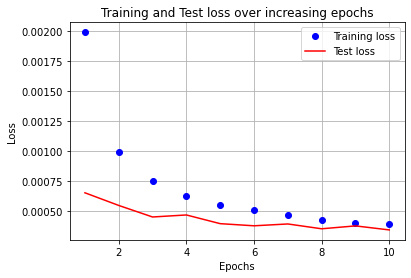

In [34]:
epochs = np.arange(10)+1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline
plt.plot(epochs, train_loss, 'bo', label='Training loss')
plt.plot(epochs, test_loss, 'r', label='Test loss')
plt.title('Training and Test loss over increasing epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()

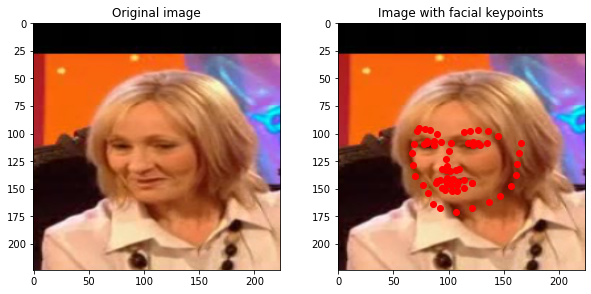

In [35]:
ix = 0
plt.figure(figsize=(10,10))
plt.subplot(221)
plt.title('Original image')
im = test_dataset.load_img(ix)
plt.imshow(im)
plt.grid(False)
plt.subplot(222)
plt.title('Image with facial keypoints')
x, _ = test_dataset[ix]
plt.imshow(im)
kp = model(x[None].to(device)).flatten().detach().cpu()
plt.scatter(kp[:68]*224, kp[68:]*224, c='r')
plt.grid(False)
plt.show()

In [36]:
!pip install -qU face-alignment

In [37]:
import face_alignment, cv2

In [38]:
!wget https://www.dropbox.com/s/2s7xjto7rb6q7dc/Hema.JPG

--2020-12-13 17:30:57--  https://www.dropbox.com/s/2s7xjto7rb6q7dc/Hema.JPG
Resolving www.dropbox.com (www.dropbox.com)... 162.125.68.18, 2620:100:6023:18::a27d:4312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.68.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/2s7xjto7rb6q7dc/Hema.JPG [following]
--2020-12-13 17:30:57--  https://www.dropbox.com/s/raw/2s7xjto7rb6q7dc/Hema.JPG
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc95cef5c53b38d6174a3ffd6313.dl.dropboxusercontent.com/cd/0/inline/BFAdw1fU-nApBysNWSmMWh8sBOcsZV9Vkn5OHa8VQXHDXPtRgjAfv8k9_bzuL5dYbvUn3wQeK5IGmU1jwGKOM3g9VOR5UbDg0jmd056KiS07S1me2aRWxTKEYMqzAxsGUSE/file# [following]
--2020-12-13 17:30:58--  https://uc95cef5c53b38d6174a3ffd6313.dl.dropboxusercontent.com/cd/0/inline/BFAdw1fU-nApBysNWSmMWh8sBOcsZV9Vkn5OHa8VQXHDXPtRgjAfv8k9_bzuL5dYbvUn3wQeK5IGmU1jwGKOM3g9VOR5UbDg0jmd056KiS07S1me2aRWxTKE

In [ ]:
fa = face_alignment.FaceAlignment(face_alignment.LandmarksType._2D,flip_input=False, device='cpu')